## Setup

In [24]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import time
from datetime import datetime


import numpy as np

import matplotlib.pyplot as plt
from scripts.model_builder import get_model, save_model

from scripts.model_configs import *

from priors.utils import plot_features
from priors.utils import uniform_int_sampler_f


from notebook_utils import *

In [26]:
large_datasets = True
max_samples = 10000 if large_datasets else 5000
bptt = 10000 if large_datasets else 3000
suite='cc'

In [27]:
device = 'cpu'
base_path = '.'
max_features = 100

In [28]:
def print_models(model_string):
    print(model_string)

    for i in range(80):
        for e in range(50):
            exists = Path(os.path.join(base_path, f'models_diff/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt')).is_file()
            if exists:
                print(os.path.join(base_path, f'models_diff/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt'))
        print()

In [29]:
def train_function(config_sample, i, add_name=''):
    start_time = time.time()
    N_epochs_to_save = 50
    
    def save_callback(model, epoch):
        if not hasattr(model, 'last_saved_epoch'):
            model.last_saved_epoch = 0
        if ((time.time() - start_time) / (maximum_runtime * 60 / N_epochs_to_save)) > model.last_saved_epoch:
            print('Saving model..')
            config_sample['epoch_in_training'] = epoch
            save_model(model, base_path, f'models_diff/prior_diff_real_checkpoint{add_name}_n_{i}_epoch_{model.last_saved_epoch}.cpkt',
                           config_sample)
            model.last_saved_epoch = model.last_saved_epoch + 1 # TODO: Rename to checkpoint
    
    model = get_model(config_sample
                      , device
                      , should_train=True
                      , verbose=1
                      , epoch_callback = save_callback)
    
    return

## Define prior settings

In [30]:
def reload_config(config_type='causal', task_type='multiclass', longer=0):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'], config['differentiable'], config['flexible'] = 'prior_bag', True, True
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

## Visualize Prior samples

In [31]:
config, model_string = reload_config(longer=1)

config['bptt_extra_samples'] = None

# diff
config['output_multiclass_ordered_p'] = 0.
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']

config['multiclass_type'] = 'rank'
del config['differentiable_hyperparameters']['multiclass_type']

config['sampling'] = 'normal' # vielleicht schlecht?
del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True
# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'
config['normalize_to_ranking'] = False # False

config['categorical_feature_p'] = .2 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .1 # diff: 1.

config['normalize_with_sqrt'] = False

config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None

config['normalize_ignore_label_too'] = False

config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = False # False heisst eig True

config['emsize'] = 512
config['nhead'] = config['emsize'] // 128
config['bptt'] = 1024+128
config['canonical_y_encoder'] = False

    
config['aggregate_k_gradients'] = 8
config['batch_size'] = 8*config['aggregate_k_gradients']
config['num_steps'] = 1024//config['aggregate_k_gradients']
config['epochs'] = 400
config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = True
config['efficient_eval_masking'] = True

config_sample = evaluate_hypers(config)

Using style prior: True
Using cpu:0 device
Using a Transformer with 25.82 M parameters
PRIOR_BAG: tensor([1.0000, 9.9396]) [1]
{'is_causal': True, 'num_causes': 3, 'prior_mlp_hidden_dim': 210, 'num_layers': 2, 'noise_std': 0.0018416263078489595, 'y_is_effect': True, 'pre_sample_weights': False, 'prior_mlp_dropout_prob': 0.5982781036293382, 'pre_sample_causes': True}
Hparams dict_keys(['prior_bag_exp_weights_1', 'num_layers_alpha', 'num_layers_scale', 'prior_mlp_hidden_dim_alpha', 'prior_mlp_hidden_dim_scale', 'prior_mlp_dropout_prob_b', 'prior_mlp_dropout_prob_k', 'noise_std_log_mean', 'noise_std_log_std', 'init_std_log_mean', 'init_std_log_std', 'num_causes_alpha', 'num_causes_scale', 'is_causal_choice_1_weight', 'pre_sample_weights_choice_1_weight', 'y_is_effect_choice_1_weight', 'prior_mlp_activations_choice_1_weight', 'prior_mlp_activations_choice_2_weight', 'block_wise_dropout_choice_1_weight', 'sort_features_choice_1_weight', 'in_clique_choice_1_weight', 'outputscale_log_mean', '

/home/urkax/miniconda3/envs/tabpfnenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/urkax/miniconda3/envs/tabpfnenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


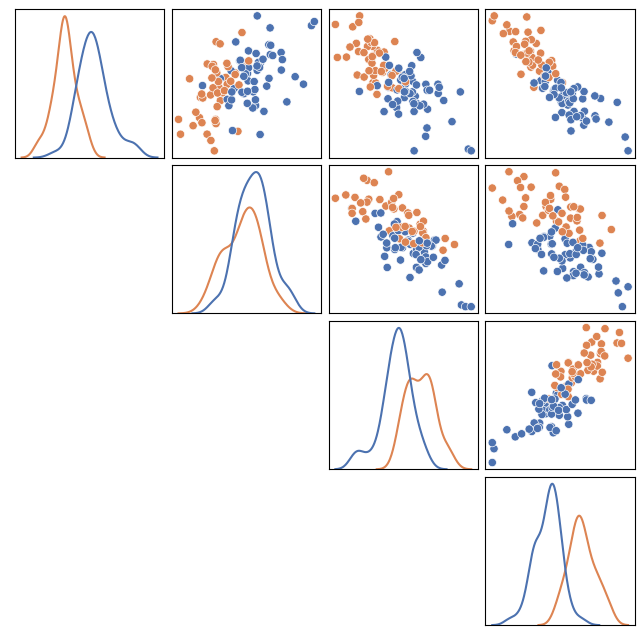

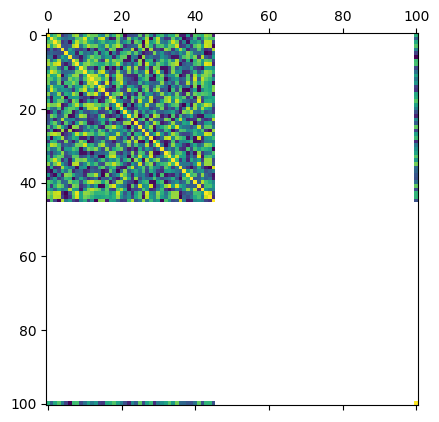

In [10]:
config_sample['batch_size'] = 4
model = get_model(config_sample, device, should_train=False, verbose=2) # , state_dict=model[2].state_dict()
(hp_embedding, data, _), targets, single_eval_pos = next(iter(model[3]))

from utils import normalize_data
fig = plt.figure(figsize=(8, 8))
N = 100
plot_features(data[0:N, 0, 0:4], targets[0:N, 0], fig=fig)

d = np.concatenate([data[:, 0, :].T, np.expand_dims(targets[:, 0], -1).T])
d[np.isnan(d)] = 0
c = np.corrcoef(d)
plt.matshow(np.abs(c), vmin=0, vmax=1)
plt.show()

## Training

In [14]:
model = get_model(config_sample, device, should_train=True, verbose=2)


Using style prior: True
Using cpu:0 device
Using a Transformer with 25.82 M parameters
PRIOR_BAG: tensor([1.0000, 7.8683]) [1]
{'is_causal': True, 'num_causes': 9, 'prior_mlp_hidden_dim': 20, 'num_layers': 8, 'noise_std': 0.0014134890851404906, 'y_is_effect': False, 'pre_sample_weights': False, 'prior_mlp_dropout_prob': 0.5468396868775436, 'pre_sample_causes': True}
Hparams dict_keys(['prior_bag_exp_weights_1', 'num_layers_alpha', 'num_layers_scale', 'prior_mlp_hidden_dim_alpha', 'prior_mlp_hidden_dim_scale', 'prior_mlp_dropout_prob_b', 'prior_mlp_dropout_prob_k', 'noise_std_log_mean', 'noise_std_log_std', 'init_std_log_mean', 'init_std_log_std', 'num_causes_alpha', 'num_causes_scale', 'is_causal_choice_1_weight', 'pre_sample_weights_choice_1_weight', 'y_is_effect_choice_1_weight', 'prior_mlp_activations_choice_1_weight', 'prior_mlp_activations_choice_2_weight', 'block_wise_dropout_choice_1_weight', 'sort_features_choice_1_weight', 'in_clique_choice_1_weight', 'outputscale_log_mean', '